In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.special import kl_div


In [2]:
import random

random.seed(20240530)

In [4]:
import time 
import seaborn as sns

## Data Generating Process


In [5]:

## True Exposure Model and Data Generating Process 
def logistic_row(row):
    return np.exp(row) / np.sum(np.exp(row))

def dim_est(obs_T, obs_C, treated_probability, Q):
    n1,n0 = len(obs_T), len(obs_C)
    tau1 = np.sum(obs_T) / (Q*treated_probability)
    tau0 = np.sum(obs_C)/(Q * (1-treated_probability))
    estimate = tau1 - tau0
    var = np.sum((obs_T - tau1)**2)/ Q/treated_probability**2  + np.sum((obs_C - tau0)**2)/ Q/(1-treated_probability)**2 
    return estimate, var

def DGP_new_homogeneous(J, Q, K, promo_ratio, query_matrix, selected_indices, X_goodbads, X_utility, treated_probability=0.5, treat_control_pool = [True, False]):
    ## Randomize over the treatment assignment matrix 
    treatment_dict = {}
    for j in range(J):
        treatment_dict[j] = np.random.choice(treat_control_pool, 1, p=[treated_probability, 1 - treated_probability])

    W_matrix = []
    for each_query in range(Q):
         W_matrix = np.append(W_matrix, [treatment_dict[ind] for ind in selected_indices])

    outcome_noise =  np.random.normal(size=(Q, K)) 
    W_matrix = W_matrix.reshape(Q,K)
    # W_matrix = W_matrix.reshape(Q,K)
    final_score_matrix = W_matrix * promo_ratio   + X_utility

    X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
    expose_indices = np.array([np.random.choice(np.arange(K), size = 1, p = X_logit[i,:]) for i in range(Q)])
    inddds = np.array(list(np.arange(K)) * Q).reshape(Q,K)
    exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q)])

    ## Outcome model  
    ## First: a true outcome model of Exponential 
    outcome_potential = X_utility

    return query_matrix, X_goodbads, X_utility,W_matrix, exposure_matrix, outcome_potential, X_logit


In [6]:
## Number of videos 
J = 20 
## Consideration set size 
K = 5 
k=5
## Generate some queries along with the recommendation model 
Q = 800
utility_score_matrix = np.ones((Q,J))

good_bad_dict = {} 
treatment_dict = {} 
utility_score = {} 
for j in range(J):
    good_bad_dict[j] = np.random.choice([True,False], 1)
    utility_score[j] = np.random.uniform()
X_goodbads = []
X_utility = []
query_matrix = []
for each_query in range(Q):
    ## Form the consideration set 
    selected_indices = np.random.choice(np.arange(J), K, replace= False)
    query_matrix += [selected_indices]
    X_goodbads = np.append(X_goodbads,[good_bad_dict[ind] for ind in selected_indices])
    X_utility = np.append(X_utility, [utility_score_matrix[each_query, ind] for ind in selected_indices])
X_goodbads = X_goodbads.reshape(Q, K)
X_utility = X_utility.reshape(Q, K)
results_df = pd.DataFrame()

In [16]:
dim_B, dim_var_B= [],[]
truth= []
## Number of MC simulations
B = 200

treated_probability = 0.5

for uplift_ratio in np.linspace(-1, 1, 20):
    print(f"Start K = {K}, Q = {Q}, J = {J}, uplift_ratio = {uplift_ratio}")
    # Ground truth
    result_T = DGP_new_homogeneous(J, Q, K, uplift_ratio, query_matrix, selected_indices, X_goodbads, X_utility,  treated_probability=1)
    result_C = DGP_new_homogeneous(J, Q, K, uplift_ratio, query_matrix, selected_indices, X_goodbads, X_utility,  treated_probability=0)
    T_gt = np.sum(result_T[-1] * X_utility , axis = 1 )
    C_gt = np.sum(result_C[-1] * X_utility , axis = 1 )
    ground_truth = np.mean(T_gt) - np.mean(C_gt)
    truth.append(ground_truth)
    print(f"True ATE {ground_truth}")

    # DIM
    dim_b, dim_var_b= [],[]

    ## True Outcome Model test 
    for b in range(B):
        if b % 100 == 0:
            print(b)
        ## DGP and data pre-processing 
        (query_matrix, X_goodbads,X_utility,W_matrix, 
         exposure_matrix, outcome_potential, X_logit)= DGP_new_homogeneous(J, Q, K, uplift_ratio, query_matrix, 
                                                                           selected_indices, X_goodbads, X_utility, 
                                                                           treated_probability=treated_probability, 
                                                                           treat_control_pool = [True, False])
        observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
        observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )

        T, C = observed_outcome[observed_queries_treatment == 1] , observed_outcome[observed_queries_treatment == 0]  
        
        dim_point, dim_var = dim_est(T, C, treated_probability, Q)
        dim_b += [dim_point]
        dim_var_b += [dim_var]


    df = pd.DataFrame({"dim": dim_b, "dim_var":dim_var_b, "J" : J,"Q": Q, "K":K, "uplift_ratio":uplift_ratio})
    results_df = pd.concat([df, results_df])
    # result_df.to_csv("result2405new/new_heterogeneous_{}_synthetic_ab_j{}q{}k{}_100_{}.csv".format(str(int(time.time())),str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))
    # plt.figure() 
    # # plt.hist(dim_B)
    # sns.histplot(result_df, x='dim', stat='density')
    
    # #sns.kdeplot(np.array(dim_B) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
    # # plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
    # plt.legend()
    print(f"DIM mean {np.mean(dim_b)} stderr {np.std(dim_b)/np.sqrt(B)}")
    dim_B.append(dim_b)
    dim_var_B.append(dim_var_b)

Start K = 5, Q = 800, J = 20, uplift_ratio = -1.0
True ATE 0.0
0
100
DIM mean -0.758 stderr 0.06130097878500799
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.8947368421052632
True ATE 0.0
0
100
DIM mean -0.69645 stderr 0.059290625207531755
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.7894736842105263
True ATE -1.1102230246251565e-16
0
100
DIM mean -0.6014499999999999 stderr 0.06080561846984207
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.6842105263157895
True ATE 0.0
0
100
DIM mean -0.42504999999999993 stderr 0.060606445511183056
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.5789473684210527
True ATE 0.0
0
100
DIM mean -0.392475 stderr 0.06757083318174344
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.4736842105263158
True ATE -1.1102230246251565e-16
0
100
DIM mean -0.4048999999999999 stderr 0.06240596886516546
Start K = 5, Q = 800, J = 20, uplift_ratio = -0.368421052631579
True ATE 0.0
0
100
DIM mean -0.2659 stderr 0.06606382103693366
Start K = 5, Q = 800, J = 20, uplift_ra

In [14]:
results_df.query("uplift_ratio==1.0")

,dim,dim_var,J,Q,K,uplift_ratio
0,1.690,2.856100,20,800,5,1.0
1,1.275,1.625625,20,800,5,1.0
2,2.000,4.000000,20,800,5,1.0
3,1.220,1.488400,20,800,5,1.0
4,-2.000,4.000000,20,800,5,1.0
...,...,...,...,...,...,...
95,0.645,0.416025,20,800,5,1.0
96,1.240,1.537600,20,800,5,1.0
97,0.535,0.286225,20,800,5,1.0
98,1.600,2.560000,20,800,5,1.0


In [20]:
results_df['DIM Bias'] = ['Positive Bias' if r > 0 else 'Negative Bias' for r in results_df['uplift_ratio']]

In [68]:
results_df.to_csv("results3005/dim_bias.csv")

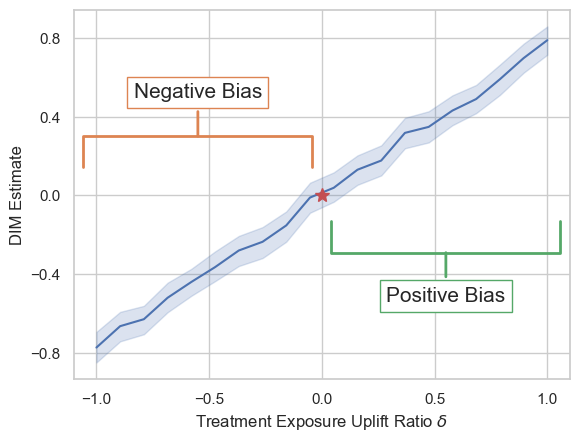

In [69]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=results_df, x="uplift_ratio", y="dim")
c = sns.color_palette()
ax.annotate('Negative Bias', xy=(0.25, 0.65), xytext=(0.25, 0.75), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color=c[1]),
            arrowprops=dict(arrowstyle="-[, widthB=5.5, lengthB=1.5", lw=2.0, color=c[1]))
ax.plot(0, 0, marker="*", color="r", markersize=10)
ax.annotate('Positive Bias', xy=(0.75, 0.35), xytext=(0.75, 0.2), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color=c[2]),
            arrowprops=dict(arrowstyle="-[, widthB=5.5, lengthB=1.5", lw=2.0, color=c[2]))
ax.set_xlabel("Treatment Exposure Uplift Ratio $\delta$")
ax.set_ylabel("DIM Estimate")
ax.set_xticks([-1.0, -0.5, 0, 0.5, 1.0])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
plt.savefig("results3005/dim_bias.pdf")